<a href="https://colab.research.google.com/github/anujpatel96/Assesment/blob/main/Interview_Preparation_Work_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Service Qualtiy
##  Data Analysis on Incidents

An incident is an event that could lead to loss of, or disruption to, an organization's operations, services or functions. An Incident is defined as an unplanned interruption or reduction in quality of an IT service (a Service Interruption). 

Here, Incidents information are captured for multiple customers for the last few months by the Company. Customers have different locations/sites and have circuits associated with those sites. These circuits are also related to products. There are critical timestamps capturing life cycle milestones. Issue reason and closure reason capture additional information on the incidents.  

There are four datasets which provides specific information about incidents, customers, service-target and measured-reason. The datasets I used are descibed below.

*   **1.Fact_Sheet:-** This dataset contains information about the incidents such as inc_id, inc_creation_date , inc_resoultion_date, customer_name etc. 



*   **2.Customer_Sheet:-** This dataset contains information about the customers such as customer_name, customer_id , inc_site etc.



*   **3.Measurable_Reason_Sheet:-** This dataset consists of the information regarding incident's closure reason and the measured flag.



*   **4.Severity_Target:-** This dataset provides information about serverity ranging from 1 to 5 [1 being low, 5 being critical] and the company's resolution time target.









I aimed to solve following tasks by analysing the data and performing Data Preprocessing and Feature Engineering on the data.

**Task_1 - Key Volume of incidents** based on Customer, Site, Products, Issue Reason - Monthly

**Task_2 - Mean Time to Resolve (MTTR)** - Mean time taken from the creation of the incident (measured) to resolution based on Customer, Site, Products, Issue Reason - Monthly

**Task_3 - Mean Time to Resolve % (MTTR %)** - Number of incidents (measured) resolved within the target based on Customer, Site, Products, Issue Reason - Monthly 


**Task_4 - Service Availability %**
The percentage of, time service was available at a customer site 

* Down Time = Total time a service was unavailable at a customer site due to 
severity 1 or 2 (measured) incident 

* Total Planned Uptime = Total calendar days (hours) the service is set up to be available at the customer site 

* Service Availability Hours = Total Planned Uptime – Down Time 

Find Service Availability% based on Customer and Site - Monthly


**Task_5 - Any additional information we can get from data**




In [1]:
#Importing mandatory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

In [2]:
#Importing Fact_Sheet data.
fact_data = pd.read_excel("Fact_Sheet.xlsx")
fact_data

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,gbc,blooth Cmpny,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,NaN,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,NaN,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,cloud Nine superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,BC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,rbm,rosebud motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pie Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


By just looking at the above data, we can see that there are many missing values in the dataset. In addition to this, the inc_cust_id and int_cust_name have many datapoints with wrong spellings. In order to find the correct ids and names we need to check the customer_sheet data.  

In [3]:
#Importing Customer_Sheet data.
customer_data = pd.read_excel("Customer_Sheet.xlsx")
customer_data.head(10)

,inc_cust_id,inc_cust_name,inc_circuit,inc_site
0,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-BS-001
1,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-CO-001
2,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-DC-001
3,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-001
4,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,GBC-MH-002
5,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-DC-001
6,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-001
7,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,C9S-STR-002
8,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-001
9,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DMP-CO-002


In [4]:
#Importing Target_Time data.
Target_data = pd.read_excel("Severity_Target_Sheet.xlsx")
Target_data.head(10)

,Severity,Target Time To Resolve
0,1,2
1,2,4
2,3,8
3,4,24
4,5,48


In [5]:
measurable_reason_data = pd.read_excel("Measurable_reason_Sheet.xlsx")
measurable_reason_data.head(10)

,inc_closure_reason,measure_flag
0,Interface Config Change,1
1,Dropped & Recovered,1
2,No Trouble Found,0
3,Ticket Cancelled,0
4,Host Config Change,1
5,Circuit Config Change,1
6,Switch Incident Closed,1
7,Server Incident Closed,1
8,Power Supply Back,1
9,Switch Config Change,1


In [6]:
fact_data[["inc_cust_id"]].describe()

,inc_cust_id
count,131
unique,22
top,DMP
freq,13


In [7]:
fact_data[["inc_cust_name"]].describe()

,inc_cust_name
count,149
unique,28
top,Bluth Company
freq,15


In Fact_sheet dataset, there are 22 and 28 unique values of customer_id and customer_name respectively. We need to verify this unqiue values by checking the customer_sheet dataset.

In [8]:
customer_data[["inc_cust_id"]].describe()

,inc_cust_id
count,27
unique,7
top,DMP
freq,6


In [9]:
customer_data[["inc_cust_name"]].describe()

,inc_cust_name
count,27
unique,7
top,"Dunder Mifflin Paper Company, Inc."
freq,6


By examining the customer_data, we found that there is a vast differene between the unique values of the same feature in different datasets. This indicated that the Fact_Sheet dataset has wrong values of features. You can see that we have one more common feature - "inc_site" in both dataset. So I compared its unique values in both datasets. 

In [10]:
fact_data[["inc_site"]].describe()

,inc_site
count,155
unique,26
top,PPI-SVC-001
freq,14


In [11]:
customer_data[["inc_site"]].describe()

,inc_site
count,27
unique,25
top,IBB-WFL-001
freq,2


By comparing unique values of "inc_site" in both datasets, I got to know that the difference is only 1 so I can use this feature to correct the values of customer_id and customer_name. 
Also the "inc_site" includes the customer_id in its value.

E.g inc_site = "GBC-MH-002" depicts the customer_id "GBC". 

In [12]:
for i in range(len(fact_data)):
    fact_data["inc_cust_id"][i] = fact_data["inc_site"][i][:3]
fact_data[["inc_cust_id"]].describe()
print(fact_data[["inc_cust_id"]]["inc_cust_id"].unique())
print(customer_data[["inc_cust_id"]]["inc_cust_id"].unique())


['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM' 'IBC']
['GBC' 'C9S' 'DMP' 'IBB' 'PPI' 'RBM' 'TAR']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Now the customer_id column is alomst ready, we just need to change one value and we can get that value by comparing unique values of customer_id from both datasets. 

In [13]:
for i in range(len(fact_data)):
    if fact_data["inc_cust_id"][i] == "IBC":
        fact_data["inc_cust_id"][i] = "IBB"
    if fact_data["inc_site"][i][:3] == "IBC":
        fact_data["inc_site"][i] = "IBB" + fact_data["inc_site"][i][3:]
print(fact_data[["inc_cust_id"]]["inc_cust_id"].unique())
print()


['GBC' 'IBB' 'TAR' 'PPI' 'C9S' 'DMP' 'RBM']



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [14]:
fact_data[["inc_site"]].describe()

,inc_site
count,155
unique,25
top,PPI-SVC-001
freq,14


We need to correct the customer_name column too. I used dictonary to save the customer_id and customer_name from customer dataset and used that same dictonary to correct fact_data.

In [15]:
dict = {}
for i in range(len(customer_data)):
    if customer_data["inc_cust_id"][i] not in dict:
        dict[customer_data["inc_cust_id"][i]] = customer_data["inc_cust_name"][i]
dict

{'C9S': 'Cloud 9 Superstore',
 'DMP': 'Dunder Mifflin Paper Company, Inc.',
 'GBC': 'Bluth Company',
 'IBB': 'Iron Bank',
 'PPI': 'Pied Piper Inc',
 'RBM': 'Rose Bud Motel',
 'TAR': 'The Alibi Room'}

In [16]:
for i in range(len(fact_data)):
    if fact_data["inc_cust_id"][i] in dict:
        fact_data["inc_cust_name"][i] = dict[fact_data["inc_cust_id"][i]]
fact_data[["inc_cust_name"]].describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,inc_cust_name
count,155
unique,7
top,"Dunder Mifflin Paper Company, Inc."
freq,30


In [17]:
fact_data

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001


### The both columns are corrected and now I can start the first task.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


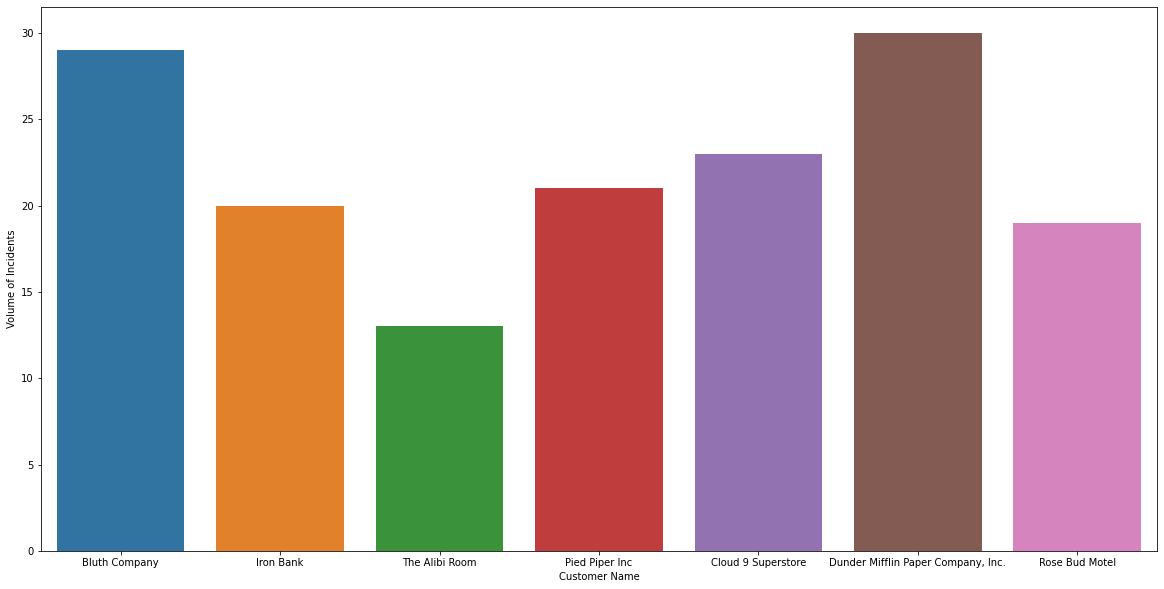

In [18]:
plt.figure(figsize=(20,10))
sns.countplot(fact_data["inc_cust_name"])
plt.ylabel("Volume of Incidents")
plt.xlabel("Customer Name")
plt.show()

By sutdying the above figure, we can see that Dunder Mifflin Paper Company, Inc.encountered highest number of incidents(30) over a period of 4 months whilst the The Alibi Room reported lowerst number of incidents(14) in a period of 4 months. Also Dunder Mifflin Paper Company has the highest sites and The Alibi Room has the lowest sites amongst all the customers. So we can say that there is a linear relationship between Number of incidents and number of sites.  

## Task_1 :- Key Volume of incidents
For the first task, I need to find the Volume of incidents based on Customer, Site, Products, Issue Reason - Monthly. So first, I created a new column "Month" containing the Month of the Incident.

In [19]:
fact_data["Month"] = "Nan"
for i in range(len(fact_data)):
    fact_data["Month"][i]= fact_data["inc_creation_dt"][i].month
fact_data.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10
5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10
6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10
7,INC072176,Ticket Manager,1,CLOSED,2020-10-06 21:00:01,2020-10-06 22:10:06,2020-10-06 22:21:04,Switch Down,Switch Incident Closed,IBB,Iron Bank,CRCTIBB-0001CKT-AAB,Fiber Internet,IBB-WFL-001,10
8,INC072177,Ticket Manager,4,CLOSED,2020-10-08 08:26:09,2020-10-09 09:35:20,2020-10-09 09:38:29,Interface State Change,No Trouble Found,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-CO-003,10
9,INC072178,Ticket Manager,2,CLOSED,2020-10-08 08:32:59,2020-10-08 12:20:38,2020-10-08 12:22:38,Circuit Down,Circuit Config Change,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-001,10


             Bluth Company  Iron Bank  ...  The Alibi Room  Rose Bud Motel
October-20               5          5  ...               2               2
November-20              8          6  ...               4               7
December-20              8          7  ...               4               3
January-20               8          2  ...               3               7

[4 rows x 7 columns]


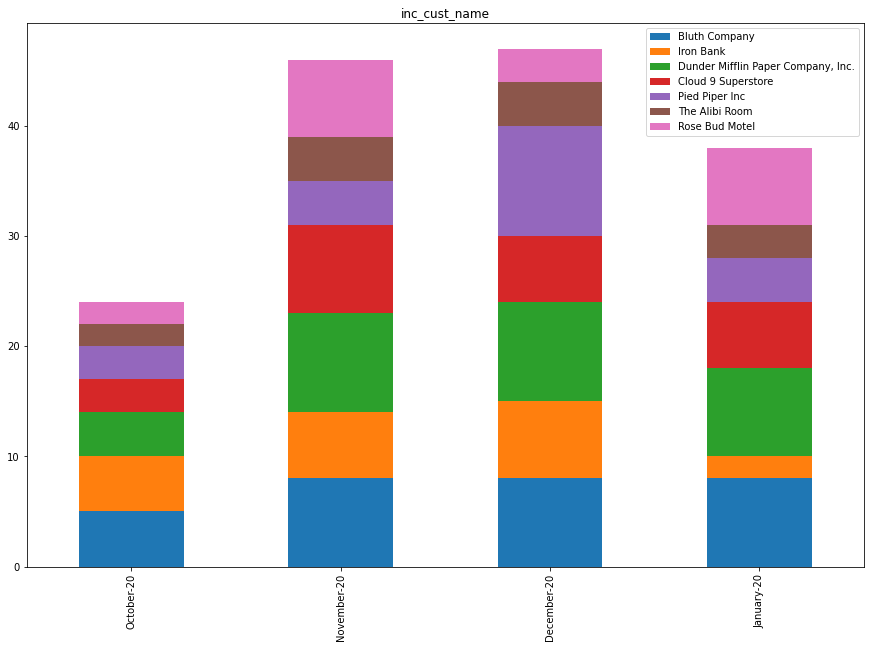

In [20]:
def bar_chart(feature):
    Oct_20 = fact_data[fact_data['Month']==10][feature].value_counts()
    Nov_20 = fact_data[fact_data['Month']==11][feature].value_counts()
    Dec_20 = fact_data[fact_data['Month']==12][feature].value_counts()
    Jan_21 = fact_data[fact_data['Month']==1][feature].value_counts()

    temp_df = pd.DataFrame([Oct_20,Nov_20,Dec_20,Jan_21])
    temp_df.index = ['October-20','November-20', 'December-20','January-20']
    temp_df.plot(kind='bar',stacked=True, figsize=(15,10))
    plt.title(feature)
    print(temp_df)

bar_chart('inc_cust_name')
#for i in fact_data[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
    #bar_chart(i)
    #print()


In the above figure, different colors represts different companies and the length of the bar of particular company represents number of incidents reported by the company.

Here, we can say that the average length of "The Alibi Room" company is lower than others and the average length of the "Dunder Mifflin Paper Company" is higher than others. 

             IBB-WFL-001  PPI-DC-001  ...  GBC-BS-001  DMP-DC-002
October-20           2.0         2.0  ...         NaN         NaN
November-20          2.0         2.0  ...         1.0         NaN
December-20          2.0         2.0  ...         1.0         NaN
January-20           NaN         1.0  ...         1.0         1.0

[4 rows x 25 columns]


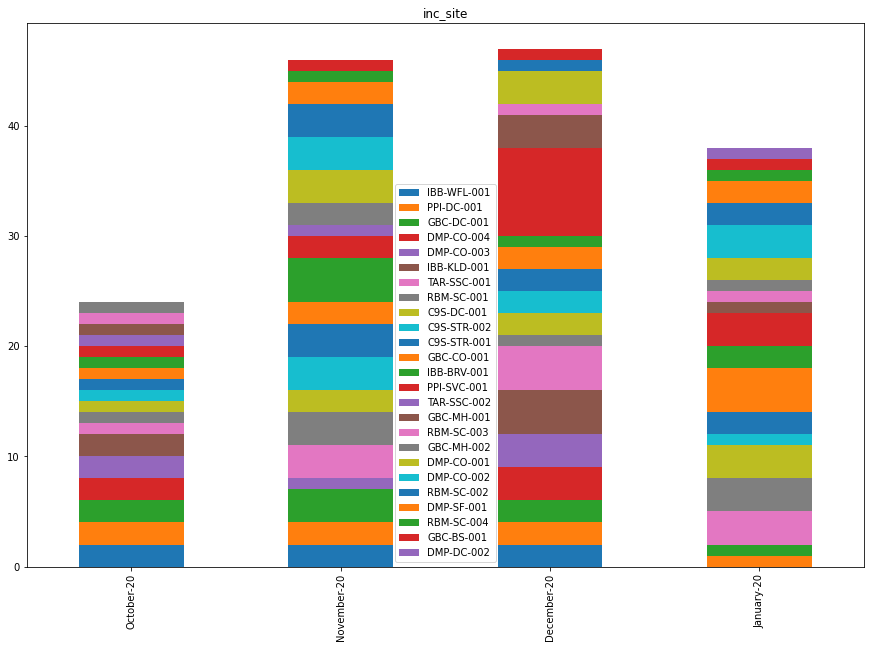

In [21]:
bar_chart('inc_site')

             Cold Start  Power Supply Fail  ...  Server Down  Router Down
October-20          3.0                3.0  ...          1.0          NaN
November-20         3.0                8.0  ...          3.0          2.0
December-20         6.0                8.0  ...          2.0          NaN
January-20          3.0                9.0  ...          2.0          2.0

[4 rows x 12 columns]


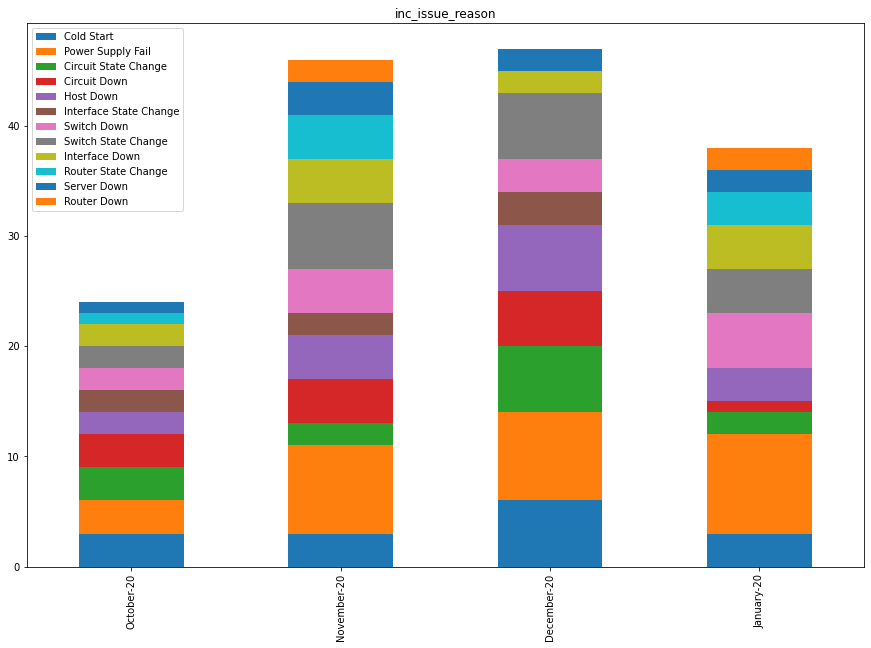

In [22]:
bar_chart('inc_issue_reason')

             DSL Internet  Fiber Internet  VOIP  ...  Data Center  VPN  PSTN
October-20            8.0             5.0   3.0  ...          1.0  NaN   NaN
November-20          15.0             8.0   3.0  ...          NaN  5.0   4.0
December-20          14.0            11.0   7.0  ...          2.0  NaN   2.0
January-20           11.0             6.0   2.0  ...          1.0  6.0   5.0

[4 rows x 9 columns]


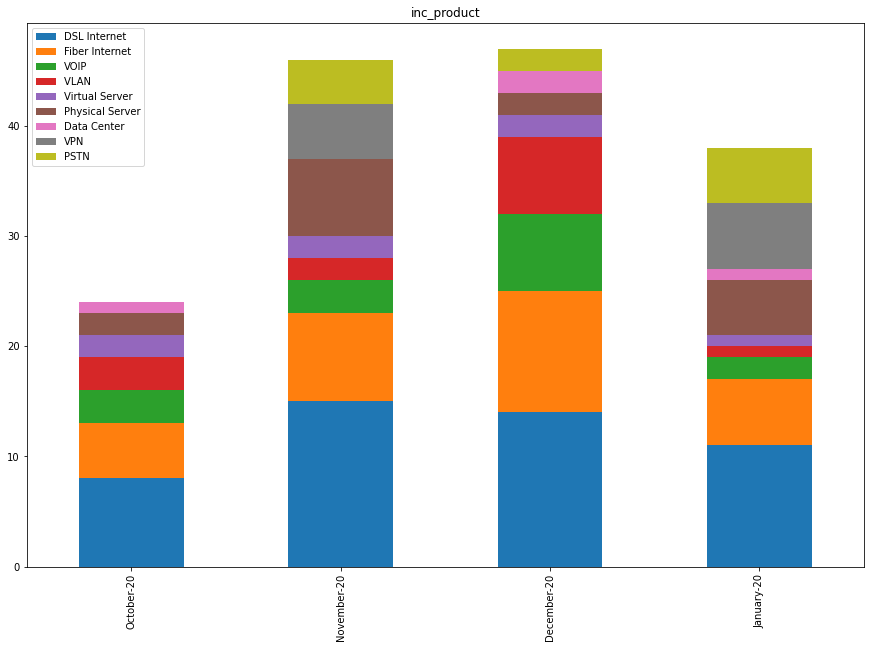

In [23]:
bar_chart('inc_product')

## Task_2 - Mean Time to Resolve (MTTR) 
In order to find the MTTR which is Mean time taken from the creation of the incident (measured) to resolution, first we need to filter our dataset with incidents having measured_flag = 0. I used the Measurable_reason dataset to check the value of incident's measured_flag. 

Then I can found the Resolution Time by applying below formula.
##### `Resolution Time = Incident_Resolution_Time - Incident_Creation_Time`

Some of values of "inc_resolution_dt" NULL as the compnay is still working on that incident. I deleted those rows as per the below code.

In [24]:
fact_data[["inc_closure_reason"]].describe()

,inc_closure_reason
count,150
unique,11
top,Dropped & Recovered
freq,41


In [25]:
measurable_reason_data[["inc_closure_reason"]].describe()

,inc_closure_reason
count,11
unique,11
top,Router Config Change
freq,1


In [26]:
dict_reason = {}
for i in range(len(measurable_reason_data)):
    if measurable_reason_data["inc_closure_reason"][i] not in dict_reason:
        dict_reason[measurable_reason_data["inc_closure_reason"][i]] = measurable_reason_data["measure_flag"][i]
dict_reason

{'Circuit Config Change': 1,
 'Dropped & Recovered': 1,
 'Host Config Change': 1,
 'Interface Config Change': 1,
 'No Trouble Found': 0,
 'Power Supply Back': 1,
 'Router Config Change': 1,
 'Server Incident Closed': 1,
 'Switch Config Change': 1,
 'Switch Incident Closed': 1,
 'Ticket Cancelled': 0}

In [27]:
fact_data["inc_closure_reason_flag"] = "Nan"
for i in range(len(fact_data)):
    if fact_data["inc_closure_reason"][i] in dict_reason:
        fact_data["inc_closure_reason_flag"][i] = dict_reason[fact_data["inc_closure_reason"][i]]
fact_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,INC072292,Ticket Manager,5,RESOLVED,2021-01-28 05:12:48,2021-01-29 11:38:24,NaT,Power Supply Fail,Power Supply Back,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Data Center,C9S-DC-001,1,1
151,INC072293,Ticket Manager,3,INPROGRESS,2021-01-04 13:11:47,NaT,NaT,Circuit State Change,NaN,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VOIP,GBC-CO-001,1,Nan
152,INC072294,Ticket Manager,1,INPROGRESS,2021-01-04 13:19:53,NaT,NaT,Switch Down,NaN,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,PSTN,RBM-SC-001,1,Nan
153,INC072295,Ticket Manager,2,INPROGRESS,2021-01-04 13:53:10,NaT,NaT,Interface Down,NaN,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Fiber Internet,PPI-SVC-001,1,Nan


##### Filtering out the incidents which measured_flag value is 0

In [28]:
fact_data_measured = fact_data[fact_data['inc_closure_reason_flag'] == 1].reset_index()
fact_data_measured

,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1


In [29]:
fact_data_measured.dropna(subset = ["inc_resolution_dt"], inplace=True)
fact_data_measured

,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1


In [30]:
fact_data_measured["Resolution Time in hours"] = "Nan"
for i in range(len(fact_data_measured)):
    difference = fact_data_measured["inc_resolution_dt"][i] - fact_data_measured["inc_creation_dt"][i]
    temp = (difference.seconds + int(str(difference)[0]) * 86400) / 3600
    fact_data_measured["Resolution Time in hours"][i] = float("{:.2f}".format(temp))
fact_data_measured

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1,14.08
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1,2.18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1,1.4
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52


inc_cust_name
             Bluth Company  ...  Pied Piper Inc
October-20            4.37  ...           25.94
November-20          13.00  ...           44.52
December-20           4.08  ...           33.04
January-21            5.32  ...           12.49

[4 rows x 7 columns]


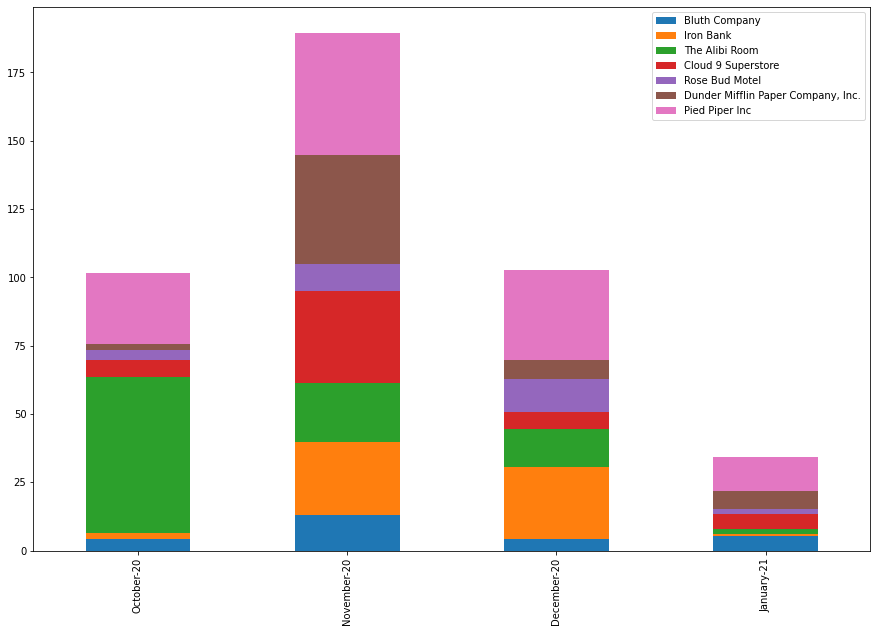

In [31]:
def bar_chart(feature):
    values = fact_data_measured[feature].unique()
    arr = {}
    for i in values:
        for j in fact_data_measured["Month"].unique():
            fact_data_by_month = fact_data_measured[fact_data_measured['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            mean_val = float("{:.2f}".format(fact_data_by_month_feature['Resolution Time in hours'].mean()))
            if i not in arr:
                arr[i] = [mean_val]
            else:
                arr[i].append(mean_val)
                
    temp_df = pd.DataFrame(data=arr) 
    temp_df.index = ['October-20','November-20', 'December-20','January-21']
    temp_df.plot(kind='bar',stacked=True, figsize=(15,10))
    print(f"{feature}")
    print(temp_df)
    print("=============================================================================")

#for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
bar_chart('inc_cust_name')


inc_site
             GBC-MH-002  IBB-BRV-001  ...  GBC-MH-001  RBM-SC-003
October-20         5.07         3.01  ...         NaN         NaN
November-20        7.91        52.68  ...         NaN         NaN
December-20         NaN         9.98  ...        8.23         NaN
January-21          NaN         0.81  ...        3.93        1.68

[4 rows x 24 columns]


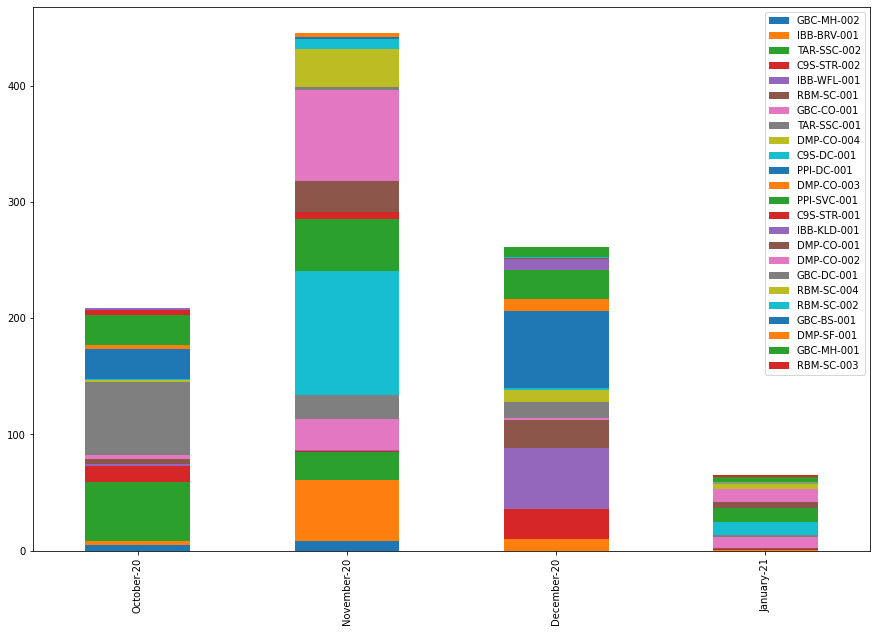

In [32]:
bar_chart('inc_site')

inc_issue_reason
             Interface Down  ...  Router Down
October-20             3.35  ...          NaN
November-20            6.04  ...        25.18
December-20            9.11  ...          NaN
January-21             0.46  ...         0.83

[4 rows x 12 columns]


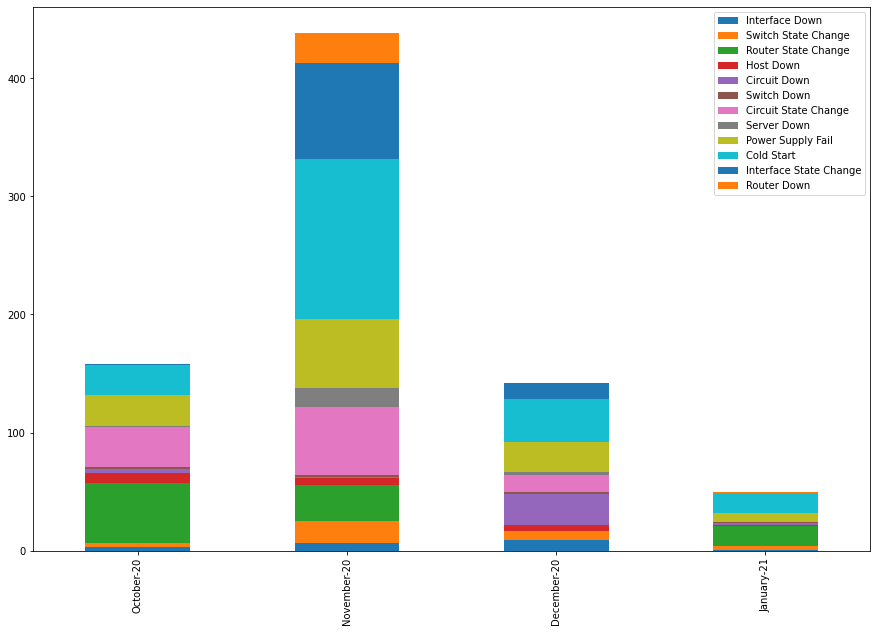

In [33]:
bar_chart('inc_issue_reason')

inc_product
             DSL Internet  VLAN   Fiber Internet  ...   PSTN  Virtual Server    VPN
October-20          25.01   2.89           10.85  ...    NaN             NaN    NaN
November-20         19.24   4.17           16.24  ...  20.58           29.37  32.18
December-20          7.13  17.67           28.94  ...  11.46             NaN    NaN
January-21           1.74  24.65            0.31  ...   0.86            0.51  11.05

[4 rows x 9 columns]


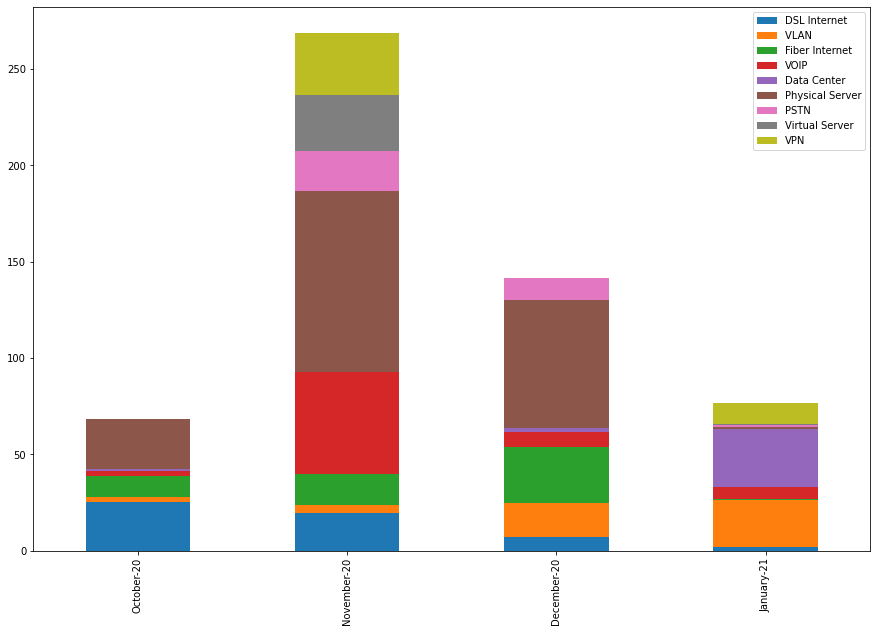

In [34]:
bar_chart('inc_product')

### Task_3 - Mean Time to Resolve % (MTTR %) - 
For Task_3 I need to find the Number of incidents(measured) resolved within the target. I am already having the "Resolution in hour" column and the data is already filtered out with measured_flag. I just need to compare it with the Serverity_Target dataset and check if the particular incident is resolved within the target time. 

##### `MTTR % = (Number of Incidents resolved in time / Total Number of Incidents) * 100`

I added a column "Resolution_in_target_time" with values,

True if Incident was resolved in target time

False if Incident was not resolved in target time

In [35]:
fact_data_measured["Resolution_in_target_time"] = "Nan"
for i in range(len(fact_data_measured)):
    for (j,k) in zip(range(len(Target_data["Severity"])), range(len(Target_data["Target Time To Resolve"]))):
        if fact_data["inc_severity"][i] == Target_data["Severity"][j]:  
            if fact_data_measured["Resolution Time in hours"][i] > Target_data["Target Time To Resolve"][k]:
                fact_data_measured["Resolution_in_target_time"][i] = False
            else:
                fact_data_measured["Resolution_in_target_time"][i] = True  
fact_data_measured

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,index,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time
0,0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07,False
1,1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01,True
2,2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91,False
3,5,INC072174,Ticket Manager,1,CLOSED,2020-10-06 19:53:00,2020-10-07 09:58:04,2020-10-07 11:33:51,Host Down,Host Config Change,C9S,Cloud 9 Superstore,CRCTC9S-0001CKT-AAA,Fiber Internet,C9S-STR-002,10,1,14.08,True
4,6,INC072175,Ticket Manager,1,CLOSED,2020-10-06 20:10:25,2020-10-06 22:21:16,2020-10-06 22:22:04,Circuit Down,Circuit Config Change,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,Fiber Internet,IBB-WFL-001,10,1,2.18,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,145,INC072289,Ticket Manager,2,CLOSED,2021-01-25 08:12:45,2021-01-25 09:36:49,2021-01-25 11:34:54,Host Down,Dropped & Recovered,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,DSL Internet,DMP-SF-001,1,1,1.4,True
115,146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81,False
116,147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68,True
117,148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52,True


        Bluth Company  ...  Pied Piper Inc
Oct_20       0.000000  ...             0.0
Nov_20      80.000000  ...            50.0
Dec_20      60.000000  ...            30.0
Jan_21      66.666667  ...            50.0

[4 rows x 7 columns]


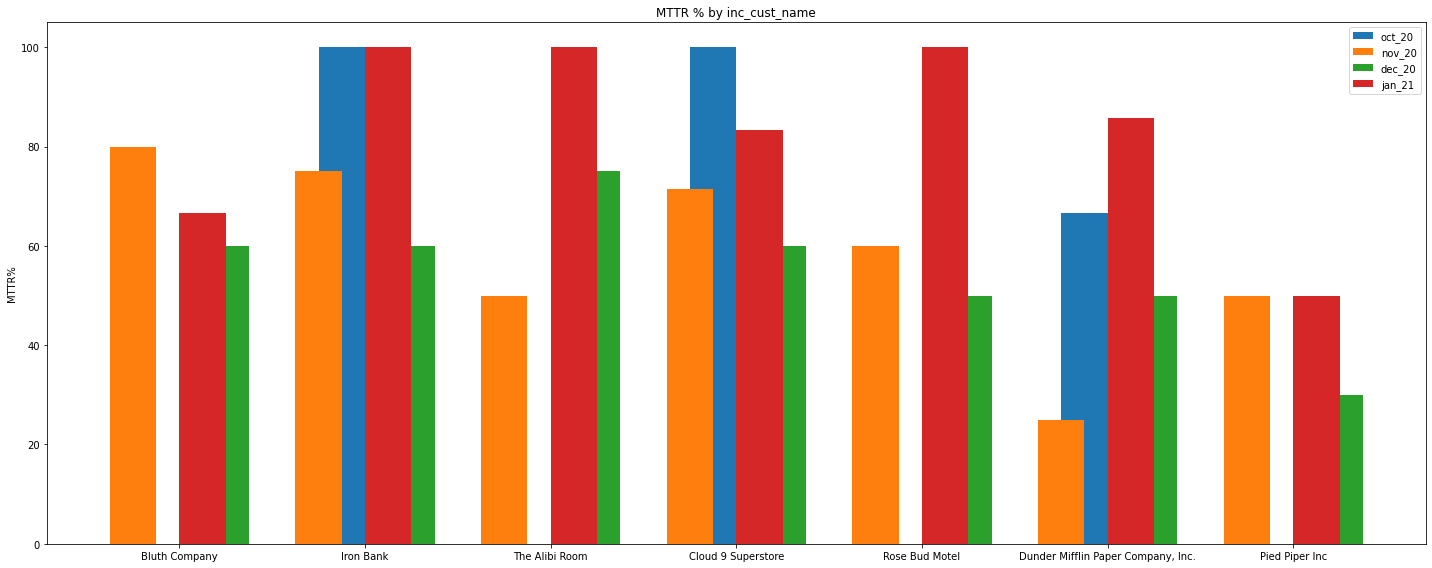

In [36]:
def bar_chart(feature):
    oct_20 = []
    nov_20 = []
    dec_20 = []
    jan_21 = []
    
    labels = fact_data_measured[feature].unique()
    for i in labels:
        for j in fact_data_measured["Month"].unique():
            fact_data_by_month = fact_data_measured[fact_data_measured['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            try:
                mttr = fact_data_by_month_feature["Resolution_in_target_time"].value_counts()[True] / fact_data_by_month_feature["Resolution_in_target_time"].count() * 100
            except:
                mttr = 0 
            if j == 10:
                oct_20.append(mttr)
            elif j == 11:
                nov_20.append(mttr)
            elif j == 12:
                dec_20.append(mttr)
            elif j == 1:
                jan_21.append(mttr)
    temp_df = pd.DataFrame([oct_20, nov_20, dec_20, jan_21], columns= labels, index = ["Oct_20", "Nov_20", "Dec_20", "Jan_21"])
    print(temp_df)
    x = np.arange(len(labels)) 
    width = 0.25

    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
    rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
    rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
    rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')

  # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MTTR%')
    ax.set_title(f'MTTR % by {feature}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

#for i in df1[['inc_cust_id','inc_site', 'inc_issue_reason', 'inc_product']]:
bar_chart("inc_cust_name")


        GBC-MH-002  IBB-BRV-001  ...  GBC-MH-001  RBM-SC-003
Oct_20         0.0        100.0  ...         0.0         0.0
Nov_20       100.0         50.0  ...         0.0         0.0
Dec_20         0.0        100.0  ...        50.0         0.0
Jan_21         0.0        100.0  ...         0.0       100.0

[4 rows x 24 columns]


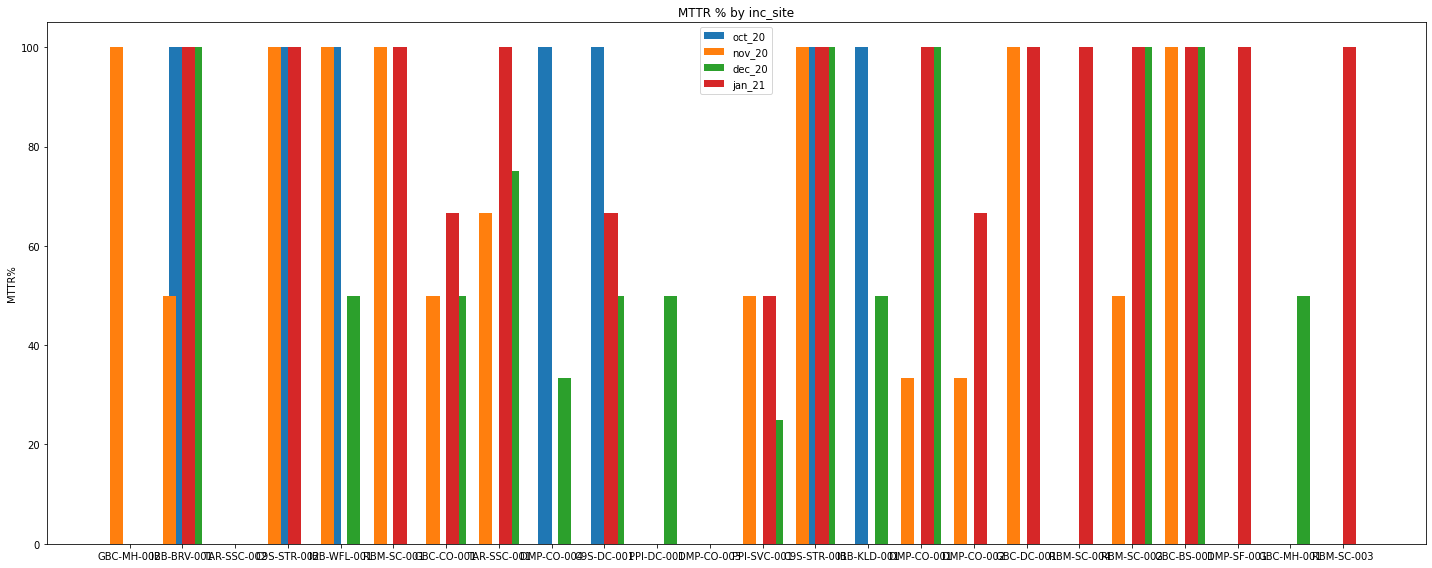

In [37]:
bar_chart("inc_site")

        Interface Down  ...  Router Down
Oct_20            50.0  ...          0.0
Nov_20           100.0  ...         50.0
Dec_20            50.0  ...          0.0
Jan_21           100.0  ...        100.0

[4 rows x 12 columns]


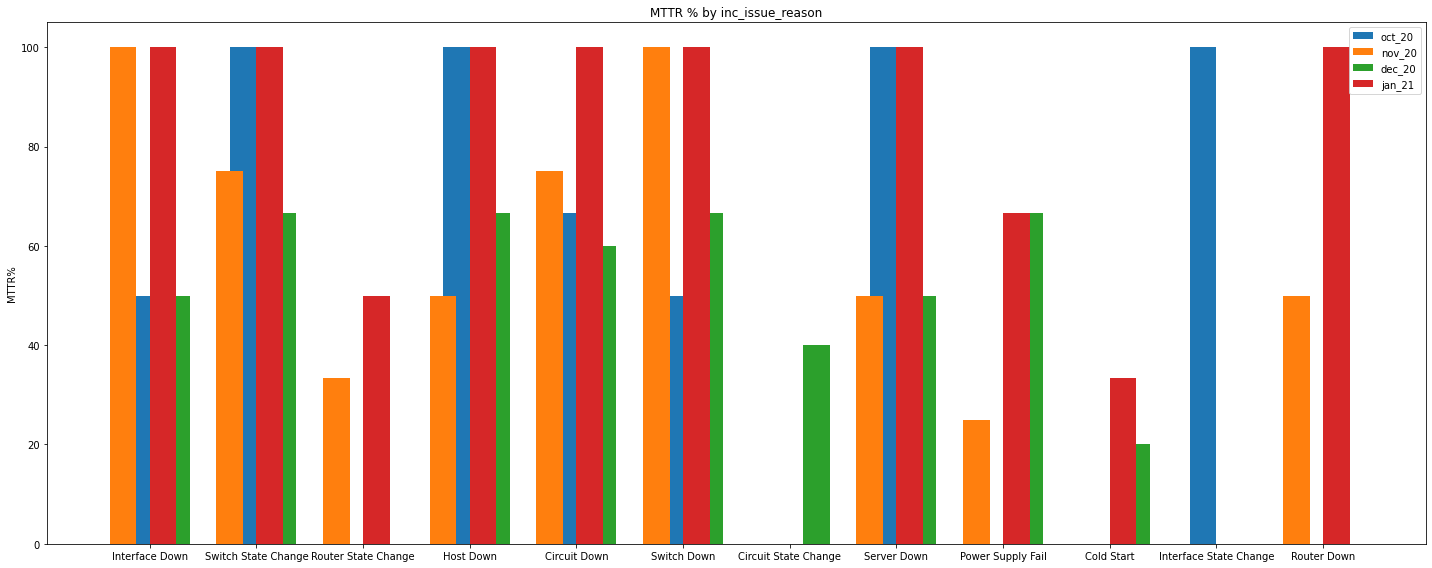

In [38]:
bar_chart("inc_issue_reason")

        DSL Internet       VLAN   ...  Virtual Server        VPN
Oct_20     20.000000  100.000000  ...             0.0   0.000000
Nov_20     66.666667  100.000000  ...             0.0  40.000000
Dec_20     63.636364   42.857143  ...             0.0   0.000000
Jan_21     88.888889    0.000000  ...           100.0  66.666667

[4 rows x 9 columns]


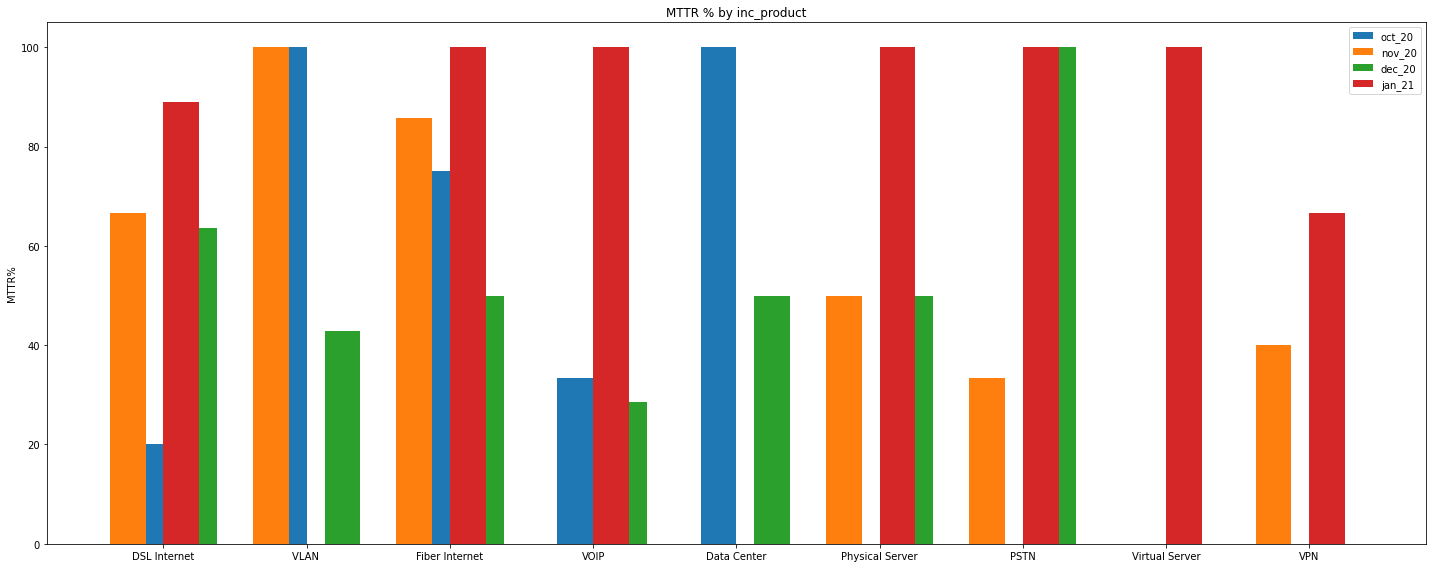

In [39]:
bar_chart("inc_product")

### Task_4 - Service Availability %
In order to get Service Availability per month, we need to first find the Total planned uptime which is the number of hours in a particular month. 
Then we can find the service availability by below formula,

Service Availability % = ((Total planned uptime - Total down time) / Total planned time ) * 100

In [40]:
fact_data.dropna(subset = ["inc_resolution_dt"], inplace=True)
fact_data
fact_data["Resolution Time in hours"] = "Nan"
for i in range(len(fact_data)):
    difference = fact_data["inc_resolution_dt"][i] - fact_data["inc_creation_dt"][i]
    temp = (difference.seconds + int(str(difference)[0]) * 86400) / 3600
    fact_data["Resolution Time in hours"][i] = float("{:.2f}".format(temp))
fact_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0,71.44
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0,71.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,Nan,1.29


         Bluth Company  ...  Rose Bud Motel
Oct_20       98.825269  ...       99.490591
Nov_20       90.970833  ...       99.737500
Dec_20       99.467742  ...       96.756720
Jan_21       99.705645  ...       99.716398
Average      97.242372  ...       98.925302

[5 rows x 7 columns]


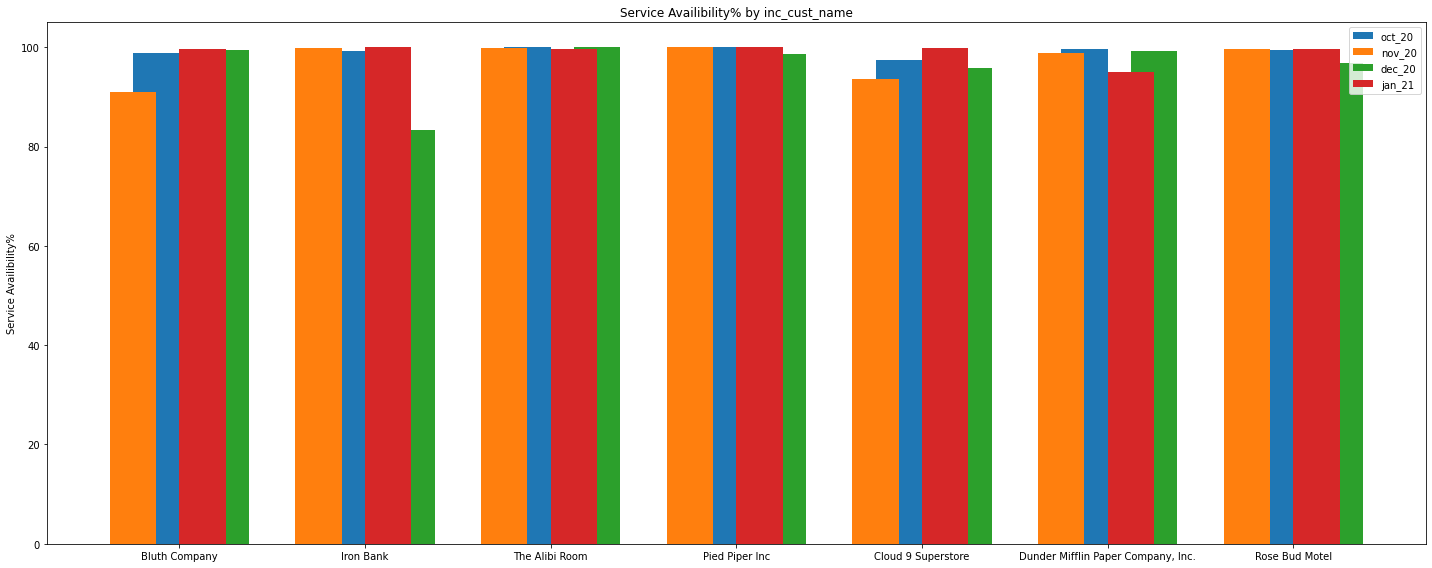

In [41]:
def bar_chart(feature):
    oct_20 = []
    nov_20 = []
    dec_20 = []
    jan_21 = []
    Average = []
    
    month_year = {10:31, 11:30, 12:31, 1:31}
    labels = fact_data[feature].unique()
    
    for i in labels:
        for j in fact_data["Month"].unique():
            fact_data_by_month = fact_data[fact_data['Month']== j]
            fact_data_by_month_feature = fact_data_by_month[fact_data_by_month[feature] == i]
            fact_data_by_month_feature_severity = fact_data_by_month_feature.loc[fact_data_by_month_feature['inc_severity'].isin([1,2])]
            down_time = fact_data_by_month_feature_severity["Resolution Time in hours"].sum()
            uptime = (month_year[j] * 24) - down_time
            service_avail = (uptime / (month_year[j] *24)) * 100
            if j == 10:
                oct_20.append(service_avail)
                service_avail = 0 
            elif j == 11:
                nov_20.append(service_avail)
                service_avail = 0 
            elif j == 12:
                dec_20.append(service_avail)
                service_avail = 0
            elif j == 1:
                jan_21.append(service_avail)
                service_avail = 0
    
    for i in range(len(oct_20)):
        Average.append(statistics.mean([oct_20[i], nov_20[i], dec_20[i], jan_21[i]]))
    
    temp_df = pd.DataFrame([oct_20, nov_20, dec_20, jan_21, Average], columns= labels, index = ["Oct_20", "Nov_20", "Dec_20", "Jan_21", "Average"])
    print(temp_df)

    x = np.arange(len(labels)) 
    width = 0.25

    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(x - width/2 , oct_20, width, label='oct_20')
    rects2 = ax.bar(x - width, nov_20, width, label='nov_20')
    rects3 = ax.bar(x + width, dec_20, width, label='dec_20')
    rects4 = ax.bar(x + width/2, jan_21, width, label='jan_21')


    ax.set_ylabel('Service Availibility%')
    ax.set_title(f'Service Availibility% by {feature}')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()
    
bar_chart("inc_cust_name")
    


         GBC-MH-002  IBB-BRV-001  ...  GBC-BS-001  DMP-SF-001
Oct_20    99.318548        100.0  ...  100.000000  100.000000
Nov_20    98.901389        100.0  ...   99.718056   99.052778
Dec_20   100.000000        100.0  ...   99.962366  100.000000
Jan_21   100.000000        100.0  ...   99.979839   99.600806
Average   99.554984        100.0  ...   99.915065   99.663396

[5 rows x 24 columns]


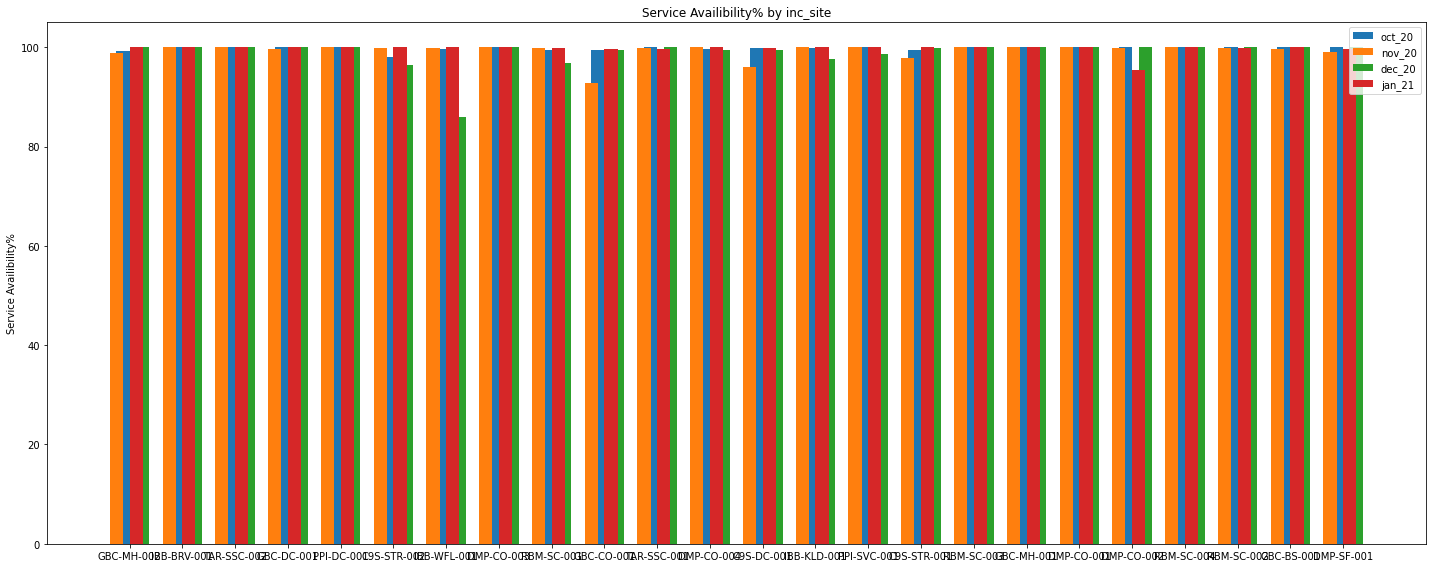

In [42]:
bar_chart("inc_site")

In [43]:
fact_data 

,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0,71.44
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0,71.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,Nan,1.29


In [44]:
fact_data["Resolution_in_target_time"] = "Nan"
for i in range(len(fact_data)):
    for (j,k) in zip(range(len(Target_data["Severity"])), range(len(Target_data["Target Time To Resolve"]))):
        if fact_data["inc_severity"][i] == Target_data["Severity"][j]:  
            if fact_data["Resolution Time in hours"][i] > Target_data["Target Time To Resolve"][k]:
                fact_data["Resolution_in_target_time"][i] = False
            else:
                fact_data["Resolution_in_target_time"][i] = True  
fact_data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,inc_number,inc_source,inc_severity,inc_status,inc_creation_dt,inc_resolution_dt,inc_closure_dt,inc_issue_reason,inc_closure_reason,inc_cust_id,inc_cust_name,inc_circuit,inc_product,inc_site,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time
0,INC072169,Ticket Manager,2,CLOSED,2020-10-02 02:54:15,2020-10-02 07:58:31,2020-10-07 08:01:51,Interface Down,Interface Config Change,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,DSL Internet,GBC-MH-002,10,1,5.07,False
1,INC072170,Ticket Manager,3,CLOSED,2020-10-02 07:15:21,2020-10-02 10:15:47,2020-10-02 10:28:24,Switch State Change,Dropped & Recovered,IBB,Iron Bank,CRCTIBB-0001CKT-AAA,VLAN,IBB-BRV-001,10,1,3.01,True
2,INC072171,Ticket Manager,3,CLOSED,2020-10-02 09:44:23,2020-10-04 12:39:10,2020-10-04 12:40:49,Router State Change,Dropped & Recovered,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,DSL Internet,TAR-SSC-002,10,1,50.91,False
3,INC072172,Ticket Manager,4,CLOSED,2020-10-05 11:24:29,2020-10-08 10:50:40,2020-10-14 16:04:25,Power Supply Fail,No Trouble Found,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,Physical Server,GBC-DC-001,10,0,71.44,False
4,INC072173,Ticket Manager,5,CANCELLED,2020-10-05 11:24:29,2020-10-08 10:55:40,2020-10-10 14:14:05,Cold Start,Ticket Cancelled,PPI,Pied Piper Inc,CRCTPPI-0001CKT-AAA,Virtual Server,PPI-DC-001,10,0,71.52,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,INC072290,Ticket Manager,5,RESOLVED,2021-01-26 01:21:08,2021-01-27 03:09:33,NaT,Cold Start,Dropped & Recovered,GBC,Bluth Company,CRCTBBC-0001CKT-AAA,VPN,GBC-CO-001,1,1,25.81,True
147,INC072192,Alarm Response,3,RESOLVED,2021-01-26 04:30:59,2021-01-26 06:12:03,NaT,Switch State Change,Dropped & Recovered,RBM,Rose Bud Motel,CRCTRBM-0001CKT-AAA,DSL Internet,RBM-SC-003,1,1,1.68,True
148,INC072193,Alarm Response,4,RESOLVED,2021-01-27 01:58:40,2021-01-27 02:29:41,NaT,Power Supply Fail,Power Supply Back,DMP,"Dunder Mifflin Paper Company, Inc.",CRCTDMP-0001CKT-AAA,VPN,DMP-CO-002,1,1,0.52,True
149,INC072291,Ticket Manager,2,RESOLVED,2021-01-27 08:55:54,2021-01-27 10:13:07,NaT,Interface Down,NaN,TAR,The Alibi Room,CRCTTAR-0001CKT-AAA,PSTN,TAR-SSC-001,1,Nan,1.29,True


In [45]:
df_fact = fact_data[['inc_creation_dt', 'inc_resolution_dt', 'inc_issue_reason', 'inc_closure_reason', 'inc_cust_name', 'inc_product','Month', 'inc_closure_reason_flag',	'Resolution Time in hours',	'Resolution_in_target_time'  ]]
df_fact

df_fact['Day'] = "Nan"

for i in range(len(df_fact)):
  df_fact['Day'][i] = df_fact['inc_creation_dt'][i].day_name()
df_fact



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versu

,inc_creation_dt,inc_resolution_dt,inc_issue_reason,inc_closure_reason,inc_cust_name,inc_product,Month,inc_closure_reason_flag,Resolution Time in hours,Resolution_in_target_time,Day
0,2020-10-02 02:54:15,2020-10-02 07:58:31,Interface Down,Interface Config Change,Bluth Company,DSL Internet,10,1,5.07,False,Friday
1,2020-10-02 07:15:21,2020-10-02 10:15:47,Switch State Change,Dropped & Recovered,Iron Bank,VLAN,10,1,3.01,True,Friday
2,2020-10-02 09:44:23,2020-10-04 12:39:10,Router State Change,Dropped & Recovered,The Alibi Room,DSL Internet,10,1,50.91,False,Friday
3,2020-10-05 11:24:29,2020-10-08 10:50:40,Power Supply Fail,No Trouble Found,Bluth Company,Physical Server,10,0,71.44,False,Monday
4,2020-10-05 11:24:29,2020-10-08 10:55:40,Cold Start,Ticket Cancelled,Pied Piper Inc,Virtual Server,10,0,71.52,False,Monday
...,...,...,...,...,...,...,...,...,...,...,...
146,2021-01-26 01:21:08,2021-01-27 03:09:33,Cold Start,Dropped & Recovered,Bluth Company,VPN,1,1,25.81,True,Tuesday
147,2021-01-26 04:30:59,2021-01-26 06:12:03,Switch State Change,Dropped & Recovered,Rose Bud Motel,DSL Internet,1,1,1.68,True,Tuesday
148,2021-01-27 01:58:40,2021-01-27 02:29:41,Power Supply Fail,Power Supply Back,"Dunder Mifflin Paper Company, Inc.",VPN,1,1,0.52,True,Wednesday
149,2021-01-27 08:55:54,2021-01-27 10:13:07,Interface Down,NaN,The Alibi Room,PSTN,1,Nan,1.29,True,Wednesday


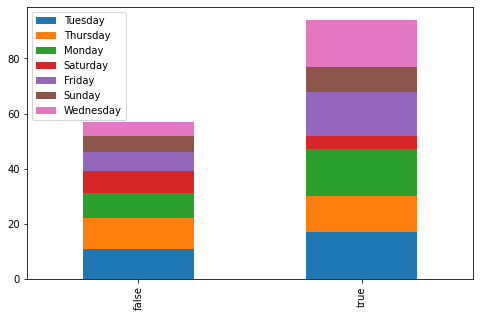

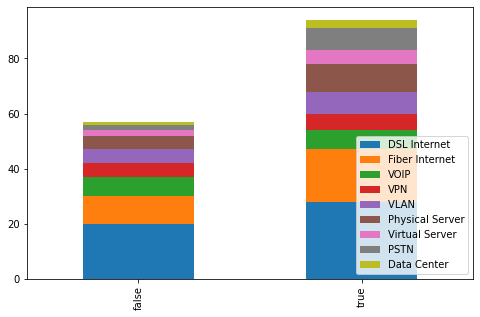

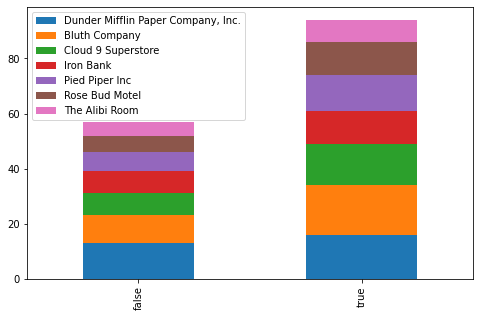

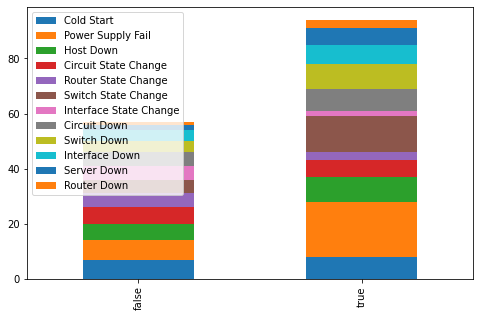

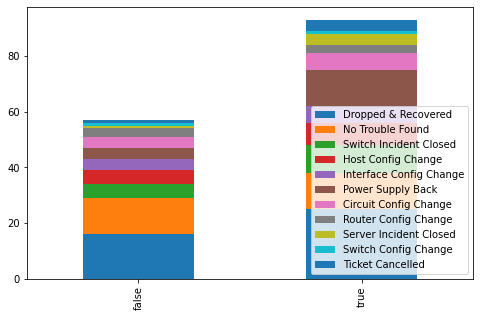

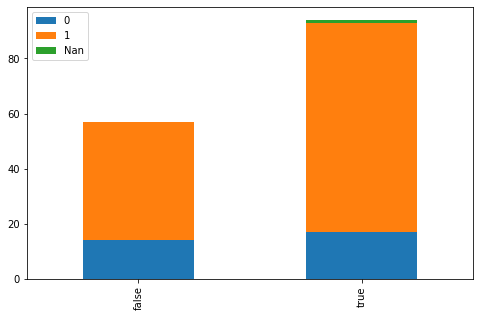

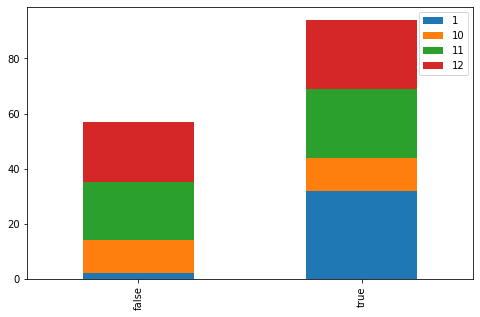

In [46]:
def bar_chart(feature):

    false = df_fact[df_fact['Resolution_in_target_time']== False][feature].value_counts()
    true = df_fact[df_fact['Resolution_in_target_time']== True][feature].value_counts()
    temp = pd.DataFrame([false,true])
    temp.index = ['false','true']
    temp.plot(kind='bar',stacked=True, figsize=(8,5))

for i in df_fact[['Day', 'inc_product', 'inc_cust_name', 'inc_issue_reason', 'inc_closure_reason', 'inc_closure_reason_flag', 'Month']]:
  bar_chart(i)



In [47]:
data = df_fact.drop(columns=["inc_resolution_dt", "Day", "inc_creation_dt", 'Resolution Time in hours', 'inc_closure_reason_flag'])
data

for i in range(len(data)):
  if data["inc_product"][i] not in ["DSL Internet", "Fiber Internet"]:
    data["inc_product"][i] = "Other"
  #if data["inc_closure_reason"][i] not in ["Router Down", "Switch State Change"]:
    #data["inc_closure_reason"][i] = "Other"
  if data["inc_cust_name"][i] not in ["Bluth Company", "Dunder Mifflin Paper Company, Inc."]:
    data["inc_cust_name"][i] = "Other"
  if data['inc_closure_reason'][i] not in ['Dropped & Recovered', "No Trouble Found", "Power Supply Back"]:
    data['inc_closure_reason'][i] = "Other"
  if data['inc_issue_reason'][i] not in ['Switch State Change', "Power Supply Fail"]:
    data['inc_issue_reason'][i] = "Other"



data.head()



,inc_issue_reason,inc_closure_reason,inc_cust_name,inc_product,Month,Resolution_in_target_time
0,Other,Other,Bluth Company,DSL Internet,10,False
1,Switch State Change,Dropped & Recovered,Other,Other,10,True
2,Other,Dropped & Recovered,Other,DSL Internet,10,False
3,Power Supply Fail,No Trouble Found,Bluth Company,Other,10,False
4,Other,Other,Other,Other,10,False


In [48]:
#data = data[data['inc_closure_reason_flag'] != "Nan"]
#data = data[['Day', 'inc_closure_reason', 'inc_product', 'Month', 'inc_closure_reason_flag', 'Resolution_in_target_time']]
x = data.iloc[:, :-1]
y = data.iloc[:,-1]
y=y.astype('int')
x

,inc_issue_reason,inc_closure_reason,inc_cust_name,inc_product,Month
0,Other,Other,Bluth Company,DSL Internet,10
1,Switch State Change,Dropped & Recovered,Other,Other,10
2,Other,Dropped & Recovered,Other,DSL Internet,10
3,Power Supply Fail,No Trouble Found,Bluth Company,Other,10
4,Other,Other,Other,Other,10
...,...,...,...,...,...
146,Other,Dropped & Recovered,Bluth Company,Other,1
147,Switch State Change,Dropped & Recovered,Other,DSL Internet,1
148,Power Supply Fail,Power Supply Back,"Dunder Mifflin Paper Company, Inc.",Other,1
149,Other,Other,Other,Other,1


In [49]:
x = pd.get_dummies(x.iloc[:,:-1])
x

,inc_issue_reason_Other,inc_issue_reason_Power Supply Fail,inc_issue_reason_Switch State Change,inc_closure_reason_Dropped & Recovered,inc_closure_reason_No Trouble Found,inc_closure_reason_Other,inc_closure_reason_Power Supply Back,inc_cust_name_Bluth Company,"inc_cust_name_Dunder Mifflin Paper Company, Inc.",inc_cust_name_Other,inc_product_DSL Internet,inc_product_Fiber Internet,inc_product_Other
0,1,0,0,0,0,1,0,1,0,0,1,0,0
1,0,0,1,1,0,0,0,0,0,1,0,0,1
2,1,0,0,1,0,0,0,0,0,1,1,0,0
3,0,1,0,0,1,0,0,1,0,0,0,0,1
4,1,0,0,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,1,0,0,1,0,0,0,1,0,0,0,0,1
147,0,0,1,1,0,0,0,0,0,1,1,0,0
148,0,1,0,0,0,0,1,0,1,0,0,0,1
149,1,0,0,0,0,1,0,0,0,1,0,0,1


In [50]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
lr = LogisticRegression(random_state = 0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
accuracy_score(y_test, y_pred)

0.6842105263157895

In [52]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
y_pred = lr.predict(x_test)
accuracy_score(y_test, y_pred)

0.6842105263157895

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score
rf = RandomForestClassifier(criterion= "entropy", random_state= 0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
accuracy_score(y_test, y_pred)

0.5526315789473685

In [54]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(x_train, y_train)
y_pred = gnb.predict(x_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.5

In [55]:
from sklearn.svm import SVC
svm = SVC(kernel= "linear", random_state= 10)
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.6842105263157895

In [56]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
accuracy_score(y_test, y_pred)

0.631578947368421